In [1]:
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
import warnings
warnings.filterwarnings('ignore') 

%matplotlib inline

import spacy
import en_core_web_sm
import string

from wordcloud import WordCloud

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from gensim import corpora, models

from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer

C:\Users\Myra\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Myra\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\Myra\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)
C:\Users\Myra\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
dataset, target = fetch_20newsgroups( shuffle=True, random_state=123, remove=('headers', 'footers', 'quotes'), return_X_y=True )

In [3]:
topics=['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [4]:
df = pd.DataFrame(list(zip(dataset, target)),
               columns =['text', 'topic'])

In [5]:
df.text.apply(lambda x: len(x.split(" "))).median()

84.0

In [6]:
unique, counts = np.unique(df.topic.values, return_counts=True)

In [7]:
counts

array([480, 584, 591, 590, 578, 593, 585, 594, 598, 597, 600, 595, 591,
       594, 593, 599, 546, 564, 465, 377], dtype=int64)

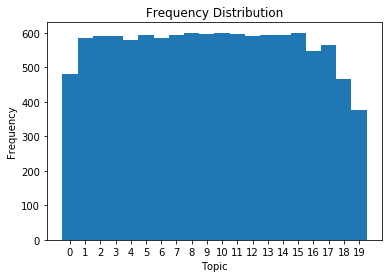

In [8]:
plt.bar(unique, counts, 1)
plt.title('Frequency Distribution')
plt.xlabel('Topic')
plt.ylabel('Frequency')
plt.xticks(range(0,20))
plt.show()

In [9]:
df=df[df.text.str.strip()!=""]

In [10]:
df.topic.unique()

array([ 4, 16, 13,  1, 19,  7,  2, 11, 12, 17, 10,  8, 15,  6, 18,  9,  0,
        3,  5, 14], dtype=int64)

In [11]:
df.shape

(11014, 2)

In [12]:
nlp = en_core_web_sm.load()

def expand_contractions(text):
    contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                 "can't": "cannot","can't've": "cannot have",
                 "'cause": "because","could've": "could have","couldn't": "could not",
                 "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                 "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                 "hasn't": "has not","haven't": "have not","he'd": "he would",
                 "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                 "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                 "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                 "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                 "it'd": "it would","it'd've": "it would have","it'll": "it will",
                 "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                 "mayn't": "may not","might've": "might have","mightn't": "might not", 
                 "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                 "mustn't've": "must not have", "needn't": "need not",
                 "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                 "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                 "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                 "she'll": "she will", "she'll've": "she will have","should've": "should have",
                 "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                 "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                 "there'd've": "there would have", "they'd": "they would",
                 "they'd've": "they would have","they'll": "they will",
                 "they'll've": "they will have", "they're": "they are","they've": "they have",
                 "to've": "to have","wasn't": "was not","we'd": "we would",
                 "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                 "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                 "what'll've": "what will have","what're": "what are", "what've": "what have",
                 "when've": "when have","where'd": "where did", "where've": "where have",
                 "who'll": "who will","who'll've": "who will have","who've": "who have",
                 "why've": "why have","will've": "will have","won't": "will not",
                 "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                 "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                 "y'all'd've": "you all would have","y'all're": "you all are",
                 "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                 "you'll": "you will","you'll've": "you will have", "you're": "you are",
                 "you've": "you have"}

    # Regular expression for finding contractions
    contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text) 
def lemmatization(input_txt):
    doc = nlp(input_txt)
    spacy_words = [t.lemma_ for t in doc if ((t.text in nlp.vocab) and (not t.is_stop) and (t.pos_ in ["ADJ","NOUN","VERB","PROPN"])  )]
    sentence=" ".join(spacy_words)
    return sentence

    
import re

def preprocess(text):
    text=expand_contractions(text)
    text=str(text).lower()    
    text=text.replace("\n"," ")
    text=text.replace("\t"," ")    
    text=re.sub(r'\S*\d+\S*', '', text)
    text=re.sub("\S*@\S*\s?",'',text)
    text=re.sub(r'[0-9]', '', text)    
    text=re.sub('[^A-Za-z ]+', ' ', text)
    text=re.sub(' +',' ',text)
    text=re.sub(r"http\S+", "", text)
    text=lemmatization(text)
    text=' '.join([w for w in text.split() if len(w)>3])
    return text

df.text=df.text.apply(lambda x: preprocess(x))

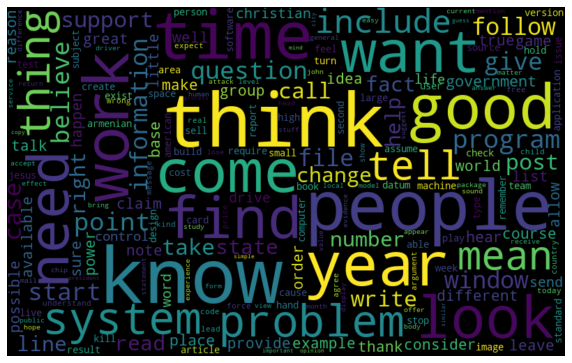

In [13]:
tokens=[x.split() for x in df.text.values]
all_words = [item for sublist in tokens for item in sublist]

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(' '.join(all_words))

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [14]:
df.head()

,text,topic
0,quick query powerbook gurus spearman post alte...,4
1,article irrational fool rkba plenty people sup...,16
2,steve look construvtive word constructive wast...,13
3,routine change color attribute adapter work mo...,1
4,wonder kekule dream influence aromatic solvent...,13


In [15]:
def find_keywords(docs):
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform(docs)
    keywords=[]
    for vector in vectors:
        names = vectorizer.get_feature_names()
        data = vector.T.todense().tolist()
        tmp = pd.DataFrame(data, index=names,columns=["tfidf"])
        tmp=tmp.sort_values(by=["tfidf"],ascending=False)
        words=tmp.index[:15].tolist()
        keywords.append(words)
    return keywords

topics_docs=df.groupby("topic",as_index=False)
topics_docs_array=[]
for topic, docs in topics_docs:
    clean_docs_array=[]
    for i, row in docs.iterrows():
        text = row['text']
        clean_docs_array.append(text)
    topics_docs_array.append(" ".join(clean_docs_array))
topics_keywords=find_keywords(topics_docs_array)

In [16]:
df_topics=pd.DataFrame({"topic":topics,"keywords":topics_keywords})

In [17]:
df_topics

,topic,keywords
0,alt.atheism,"[atheism, atheist, people, religion, think, is..."
1,comp.graphics,"[image, jpeg, file, graphic, format, program, ..."
2,comp.os.ms-windows.misc,"[window, file, problem, font, driver, windows,..."
3,comp.sys.ibm.pc.hardware,"[drive, scsi, controller, card, disk, system, ..."
4,comp.sys.mac.hardware,"[drive, apple, problem, scsi, quadra, nubus, k..."
5,comp.windows.x,"[widget, window, motif, file, program, entry, ..."
6,misc.forsale,"[sale, good, offer, include, shipping, sell, p..."
7,rec.autos,"[good, engine, drive, brake, think, know, time..."
8,rec.motorcycles,"[bike, ride, motorcycle, helmet, know, think, ..."
9,rec.sport.baseball,"[year, team, game, good, player, baseball, thi..."


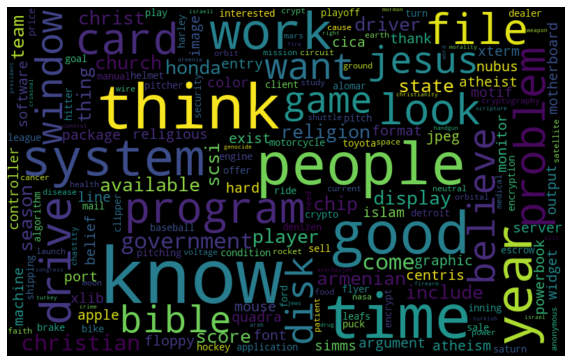

In [18]:
all_words = [item for sublist in df_topics.keywords.values for item in sublist]

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(' '.join(all_words))

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [19]:
df.text=df.text.apply(lambda x: x.split())

In [20]:
from sklearn.model_selection import train_test_split
X=df.loc[:,"text"]
y=df.loc[:,"topic"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [21]:
X_train

316      [motherboard, local, come, cirrus, logic, card...
7073     [opinion, thing, game, argument, defense, allo...
7682     [stuff, delete, stuff, delete, usenet, collect...
1798     [look, look, example, boss, seat, couple, regu...
3362     [team, mask, appear, average, helmet, cage, va...
                               ...                        
5208     [copy, disagree, good, book, look, graphic, fe...
10904    [post, john, want, tell, slight, difference, s...
3991     [discuss, liberty, permission, eric, interesti...
9903     [account, anti, armenian, human, right, azerba...
8000     [wonder, know, hard, drive, utility, work, har...
Name: text, Length: 8811, dtype: object

In [22]:
dictionary_LDA = corpora.Dictionary(X_train)
dictionary_LDA.filter_extremes(no_below=10, no_above=0.2)
corpus = [dictionary_LDA.doc2bow(doc) for doc in X_train]

In [23]:
lda_scores=[]
lda_models=[]
for i in range(6,21):    
    lda_model = models.LdaModel(corpus, num_topics=i,id2word=dictionary_LDA,alpha="auto",eta="auto",passes=10)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=X_train, dictionary=dictionary_LDA, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print("Number of topics: "+str(i))
    print('Coherence Score: ', coherence_lda,end="\n")
    lda_scores.append(coherence_lda)
    lda_models.append(lda_model)

Number of topics: 6
Coherence Score:  0.5259927446683798
Number of topics: 7
Coherence Score:  0.5010448415550756
Number of topics: 8
Coherence Score:  0.5584495659395368
Number of topics: 9
Coherence Score:  0.5306921235330354
Number of topics: 10
Coherence Score:  0.5691054791254639
Number of topics: 11
Coherence Score:  0.5798721392484816
Number of topics: 12
Coherence Score:  0.561319153889959
Number of topics: 13
Coherence Score:  0.5581600964782163
Number of topics: 14
Coherence Score:  0.5902403569610664
Number of topics: 15
Coherence Score:  0.5988066713615352
Number of topics: 16
Coherence Score:  0.5568902396996096
Number of topics: 17
Coherence Score:  0.5530640996599422
Number of topics: 18
Coherence Score:  0.5460834169319044
Number of topics: 19
Coherence Score:  0.5276521173378084
Number of topics: 20
Coherence Score:  0.5788402820053017


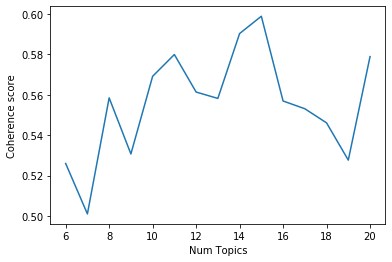

In [24]:
import matplotlib.pyplot as plt
x = range(6, 21)
plt.plot(x, lda_scores)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.show()

In [29]:
num_topics=12
i=num_topics-6
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_models[i], corpus, dictionary=lda_models[i].id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.085658 -0.080280       1        1  16.213692
9     -0.157284 -0.143305       2        1  10.455092
10     0.185886 -0.058728       3        1   9.147461
6      0.195129  0.079916       4        1   8.858852
4     -0.043506  0.088814       5        1   8.737757
2     -0.136623  0.080762       6        1   7.915635
0      0.198816 -0.063590       7        1   7.608279
7     -0.174742  0.145521       8        1   7.077920
3      0.018290  0.100766       9        1   7.025009
11    -0.192062 -0.128810      10        1   5.999966
1      0.082966  0.209701      11        1   5.715721
5      0.108788 -0.230768      12        1   5.244617, topic_info=       Term         Freq        Total Category  logprob  loglift
159    file  2101.000000  2101.000000  Default  30.0000  30.0000
132   drive  1571.000000  1571.000000  Default  29.0000  29.0000
175   thank  1181.000000  1181.000000  Default  28.0000  28.0000
171   space   917.000000   917.000000  Default  27.0000  27.0000
40     game   967.000000   967.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
182    work   204.234218  2190.647328  Topic12  -4.7210   0.5753
26     tell   162.289795  1512.361567  Topic12  -4.9509   0.7159
66     time   171.876423  2815.795546  Topic12  -4.8935   0.1517
177  window   158.289883  1408.932264  Topic12  -4.9759   0.7618
28    thing   157.659337  1789.518469  Topic12  -4.9799   0.5187

[843 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
387       5  0.020927  abide
387       6  0.041853  abide
387       9  0.920775  abide
152       1  0.111188   able
152       2  0.222377   able
...     ...       ...    ...
316       8  0.077448   year
316       9  0.023551   year
316      10  0.027175   year
316      11  0.123192   year
316      12  0.005435   year

[2504 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 10, 11, 7, 5, 3, 1, 8, 4, 12, 2, 6])

In [32]:
num_topics=12
i=num_topics-6
lda_model = lda_models[i]

In [34]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=X_test, dictionary=dictionary_LDA, coherence='c_v')

In [36]:
coherence_lda = coherence_model_lda.get_coherence()
print("Number of topics: "+str(num_topics))
print('Coherence Score: ', coherence_lda,end="\n")

Number of topics: 12
Coherence Score:  0.4852224789080664
